In [1]:
from pprint import pprint
from itertools import chain, compress
from functools import reduce, partial
from glob import iglob
from yaml import safe_load
from numba import jit
from cytoolz import compose
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from pyspark.sql.types import ArrayType, BooleanType
import matplotlib.pyplot as plt
from dltools import SpkHits, load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load config file
with open("sacla_analysis-config.yaml", "r") as file:
    print("Loading config file...")
    config = safe_load(file)
pprint(config)

Loading config file...
{'momentum_analyzer': {'dx': 1,
                       'dy': 1,
                       'models': {'particle_a': {'fr': 4561.4,
                                                 'mass': 8501.3198901104,
                                                 'pr_coeffs': [22.5668,
                                                               -0.00087779,
                                                               4.24205e-08,
                                                               -2.76085e-12,
                                                               4.22634e-11,
                                                               -1.98336e-18],
                                                 'pz_coeffs': [26824.7,
                                                               -14.2786,
                                                               0.000193147,
                                                               6.57577e-07,
                        

In [3]:
# %% Load momentum model
print("Loading momentum model...")
analyzer = load_analyzer(config["momentum_analyzer"])
print(analyzer)

Loading momentum model...
<function UserDefinedFunction._wrapped.<locals>.wrapper at 0x116142840>


In [4]:
# %% Load PySpark
print("Loading PySpark...")
builder = (SparkSession
           .builder
           .config("spark.jars.packages",
                   "org.diana-hep:spark-root_2.11:0.1.15,"
                   "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1")
           )
spark = builder.getOrCreate()
print(spark)

Loading PySpark...


In [5]:
# %% Load data
print("Loading data...")
globbed = chain.from_iterable(iglob(patt) for patt in config["target_files"])
loadme = (spark.read.format("org.dianahep.sparkroot").load(f) for f in sorted(set(globbed)))
df = restructure(reduce(DataFrame.union, loadme))
df.printSchema()
df.show()
(
    df
    .select(f.explode("hits").alias("h"))
    .select(f.col("h.t").alias("t"),
            f.col("h.x").alias("x"),
            f.col("h.y").alias("y"),
            f.col("h.flag").alias("flag"))
    .limit(20)
    .toPandas()
)

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

+---------+--------------------+
|      tag|                hits|
+---------+--------------------+
|158648231|[[803.53128890943...|
|158648232|[[804.66343712302...|
|158648233|[[794.79463683844...|
|158648234|[[786.43060318885...|
|158648235|[[709.28913731595...|
|158648236|[[627.36191628571...|
|158648237|[[899.62290167172..

,t,x,y,flag
0,803.531289,22.084287,-9.010443,13
1,805.186457,-3.410069,-2.075715,0
2,926.205980,4.763139,28.911008,0
3,944.841900,-5.041342,7.548212,17
4,1013.461017,-22.692024,-13.571205,0
5,1455.289515,1.290518,0.833531,0
6,2311.770348,2.549458,17.510870,0
7,2382.982309,2.490935,0.800476,6
8,2440.103272,-5.223339,-54.310071,18
9,2448.647841,-25.933024,-31.314864,15


In [6]:
# %% Analyze momentum
print("Analyzing momentum...")


@jit(nopython=True, nogil=True)
def isgood(flag):
    return flag <= 6


wheregood = f.udf(compose(list, partial(map, isgood)), ArrayType(BooleanType()))
hitfilter = f.udf(compose(list, partial(map, Row.asDict), compress), SpkHits)
analyzed = (
    df
    .withColumn("filtered", hitfilter("hits", wheregood("hits.flag")))
    .withColumn("analyzed", analyzer("filtered"))
)
analyzed.printSchema()
analyzed.show()
(
    analyzed
    .select(f.explode("analyzed").alias("h"))
    .select(f.explode("h.as_").alias("as_", "m"))
    .select("as_", "m.*")
    .limit(20)
    .toPandas()
)

Analyzing momentum...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: s

,as_,pz,px,py,ke
0,particle_b,-189.492725,-32.917721,45.582328,2.297809
1,particle_b,569.061709,16.217717,47.965487,19.196721
2,particle_b,66.807196,58.412904,325.463399,6.693178
3,particle_a,196.714475,-35.611128,60.151577,2.563305
4,particle_a,-52.386493,-152.524380,22.469420,1.559341
5,particle_a,110.332093,-86.407544,-43.483970,1.266291
6,particle_a,304.214238,132.412487,151.972608,7.832610
7,particle_a,125.963435,46.140288,3.578911,1.059160
8,particle_a,-132.235630,26.738194,-232.583904,4.252073
9,particle_b,305.905877,18.056126,253.429188,9.300367


In [7]:
# %% Combine hits
print("Combining hits...")
combiner = load_combiner(r=2, white_list=[["particle_b", "particle_a"]], allow_various=False, allow_dup=False)
combined = analyzed.withColumn("combined", combiner("analyzed"))
combined.printSchema()
combined.show()
(
    combined
    .select(f.explode("combined.as_").alias("h"))
    .select(f.explode("h").alias("as_", "m"))
    .select("as_", "m.*")
    .limit(20)
    .toPandas()
)

Combining hits...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |-- filtered: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struc

,as_,pz,px,py,ke
0,"particle_b,particle_a",-33.564158,-176.322749,-207.161445,5.752552
1,"particle_b,particle_a",174.375771,-239.281206,-59.523274,17.023027
2,"particle_b,particle_a",310.954810,99.115694,55.417413,12.555207
3,"particle_b,particle_a",296.535357,39.227241,139.342897,8.817966
4,"particle_b,particle_a",-147.732598,-283.825020,64.696944,3.869742
5,"particle_b,particle_a",369.613155,331.267735,-16.466848,27.461972
6,"particle_b,particle_a",55.475894,217.175777,-450.218896,14.927449
7,"particle_b,particle_a",221.306226,177.423557,94.535990,10.762195
8,"particle_b,particle_a",293.982031,-56.820172,2.866804,12.278583
9,"particle_b,particle_a",330.600792,125.268713,9.374657,13.783262


Plotting PIPICO...


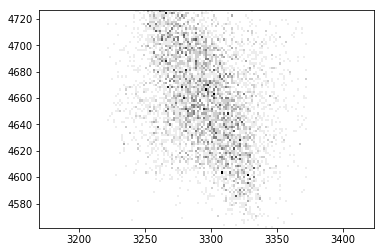

In [8]:
# Plot PIPICO
print("Plotting PIPICO...")
pdf = (
    combined
    .select(f.explode("combined").alias("h"))
    .select(f.col("h.comb")[0]["t"].alias("t0"), f.col("h.comb")[1]["t"].alias("t1"))
    .toPandas()
)
plt.figure()
plt.hist2d(pdf["t0"], pdf["t1"], bins=[100, 100], cmap="Greys")
plt.axis("equal")
plt.show()